In [9]:
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
from matplotlib import pyplot as plt

In [3]:
# Needed only once to convert jp2 to netCDF
#Change the following variables to the file you want to convert (inputfile) and
#what you want to name your output file (outputfile).
inputfile = 'D:/COPY/Projekt_FF/Data/dop10rgbi_32_468_5671_1_nw_2021.jp2'
outputfile = 'D:/COPY/Projekt_FF/Data/dop.nc'
#Do not change this line, the following command will convert the geoTIFF to a netCDF
ds = gdal.Translate(outputfile, inputfile, format='NetCDF')

In [2]:
# Define file path to DOP tile
filepath = 'D:/COPY/Projekt_FF/Data/dop.nc'

# Read DOP file as xarray.Dataset
dop = rxr.open_rasterio(filepath)
dop

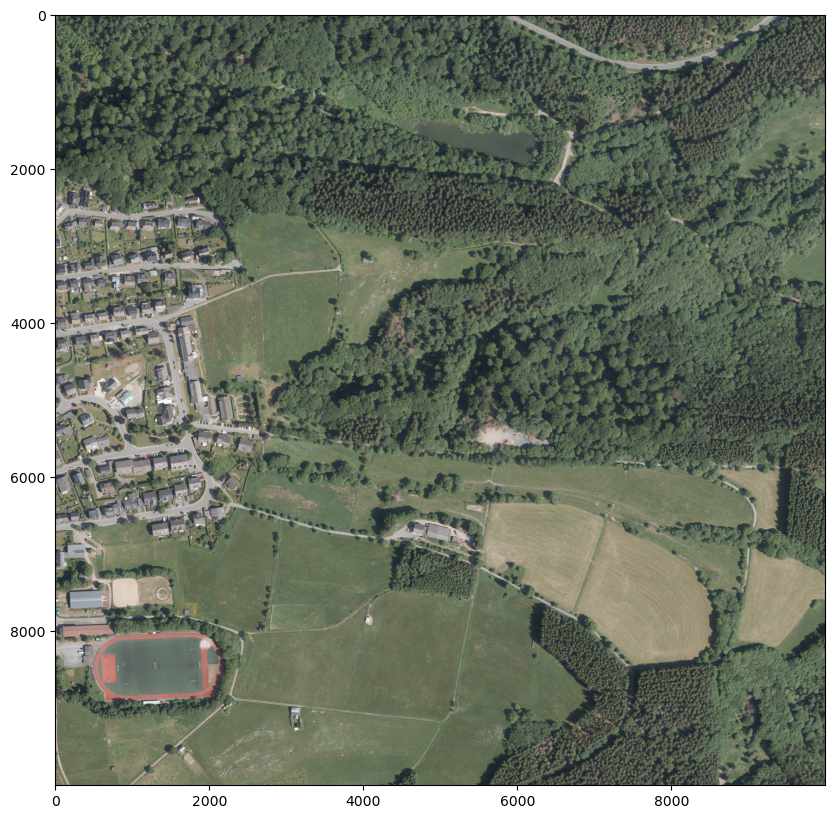

In [6]:
# Remove one dimension from the dataset
dop = dop.squeeze()

# Plot RGB image of the DOP
plt.figure(figsize=(10,10))
plt.imshow(np.array([dop.Band1, dop.Band2, dop.Band3]).transpose(1,2,0))
plt.show()

In [10]:
# Read polygons defined as 'forest' based on 'Basis DLM'
# They were pre extracted for the investigated DOP tile
forest_polygons = gpd.read_file('D:/COPY/Projekt_FF/Data/wald_dop.gpkg')

<AxesSubplot: >

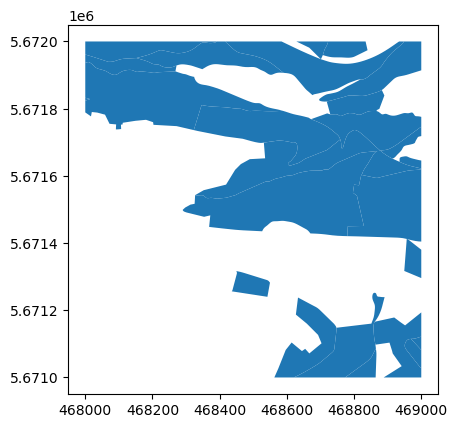

In [13]:
# Plot of the forest polygons
forest_polygons.plot()

In [15]:
# Create raster mask of the forest polygons
# which can be later used for training
# This mask will be filled with values 0 (non-forest) and 1 (forest)

# Get geometries of the polygons
geom = [shapes for shapes in forest_polygons.geometry]

# Get parameters of the DOP needed for the mask
with rasterio.open('D:/COPY/Projekt_FF/Data/dop10rgbi_32_468_5671_1_nw_2021.jp2') as src:
    profile = src.profile
print(profile["transform"])
print(profile["crs"])
print(profile["width"])

# Rasterize the polygons
trainmask = rasterize(geom, 
                      out_shape = (profile['width'], profile['height']),
                      fill=0,
                      transform=profile['transform'],
                      all_touched=True,
                      default_value=1)
trainmask

| 0.10, 0.00, 468000.00|
| 0.00,-0.10, 5672000.00|
| 0.00, 0.00, 1.00|
EPSG:25832
10000


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [16]:
# Add the mask (numpy-array) as new data variable to the DOP xarray.Dataset
dop['forest_mask']=(['x', 'y'], trainmask)
dop

<xarray.Dataset>
Dimensions:              (x: 10000, y: 10000)
Coordinates:
    band                 int32 1
  * x                    (x) float64 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y                    (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    transverse_mercator  int32 0
Data variables:
    Band1                (y, x) uint8 105 110 115 115 115 ... 103 111 102 73 38
    Band2                (y, x) uint8 112 118 124 125 126 ... 113 123 123 75 45
    Band3                (y, x) uint8 98 104 110 111 113 96 ... 91 102 105 59 9
    Band4                (y, x) uint8 ...
    forest_mask          (x, y) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.3, released 2022/10/21
    history:      Tue Nov 08 15:47:04 2022: GDAL CreateCopy( D:/COPY/Projekt_...

In [17]:
# Check if only 0 and 1 are included in the mask
np.unique(dop.forest_mask)

array([0, 1], dtype=uint8)

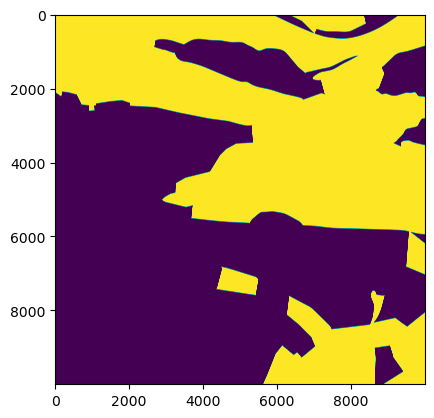

<AxesSubplot: >

In [24]:
# Quick plot of the forest mask
from rasterio.plot import show

show(trainmask)

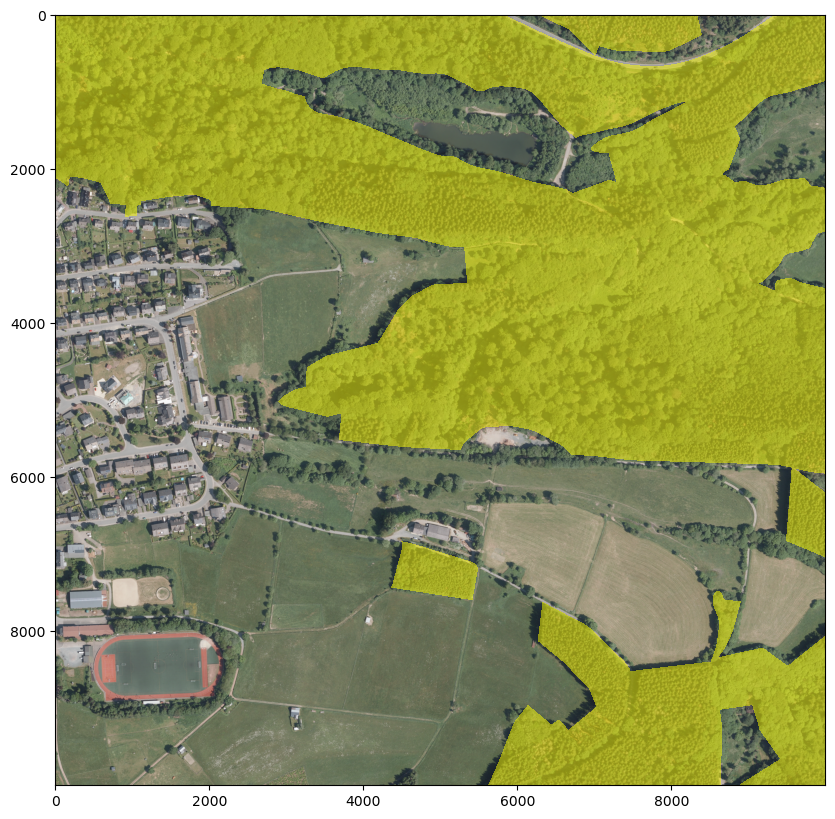

In [18]:
# Plot DOP with forest mask (only forest)
plt.figure(figsize=(10,10))
plt.imshow(np.array([dop.Band1, dop.Band2, dop.Band3]).transpose(1,2,0))
plt.imshow(np.where(dop.forest_mask==1,1,np.nan), cmap='autumn_r', interpolation='None', alpha=0.5)
plt.show()

In [21]:
# Write to disk
dop.to_netcdf('D:/COPY/Projekt_FF/Process/dop_forestmask.nc', mode='w')